# Results Explorer for lorenz models

includes plotting the sindy coefficients $\Xi$, loss metrics and trajectories for different initial conditions 

### Choose Model

In [1]:
#CHOOSE MODEL
model_path = "checkpoints/nonlinear_junmi_2/NonLinear/version_4"
#CHOOSE MODEL
save_folder = "../../images/"

In [2]:

#9 coeffs
#checkpoints/NonLinear2/version_2

#8 coeffs
#checkpoints/KathleenReplicas/version_9
#checkpoints/KathleenReplicas/version_20
#checkpoints/AltSpecs/version_4
#checkpoints/AltSpecs/version_6
#checkpoints/NonLinear1/version_0
#checkpoints/NonLinear1/version_16
#checkpoints/NonLinear2/version_12 #best
#checkpoints/NonLinear2/version_13
#checkpoints/NonLinear2/version_19

#7 coeffs
#checkpoints/NonLinear1/version_2 #bestes model
#checkpoints/NonLinear1/version_14
#checkpoints/NonLinear2/version_3
#checkpoints/NonLinear2/version_6
#checkpoints/NonLinear2/version_10
#checkpoints/NonLinear2/version_14

#6 coeffs
#checkpoints/NonLinear2/version_5 #deeecent
#checkpoints/KathleenReplicas/version_30

In [3]:
import sys
sys.path.append('../')
from trainer import SINDy_trainer, update_mask
import jax.numpy as jnp
import numpy as np
# 
#exmp input can be anythig if we are not passing any data through the model (autoencoder)
exmp_input = jnp.ones((1, 128))
trainer = SINDy_trainer.load_from_checkpoint(model_path, exmp_input)

xi_raw = trainer.state.params['sindy_coefficients']

#we don't store mask so we need to recreate it
mask = update_mask(xi_raw)

library_hparams = trainer.library_hparams

xi = xi_raw * mask
#making xi numpy array just to support assignment dont want to use .at[idx].set(val) method
xi = np.array(xi)
print(xi)

2024-06-14 18:25:37.984244: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


[[ 0.          0.          7.83622   ]
 [-9.661117   -0.         -0.        ]
 [ 9.4818735  -0.69437325  0.        ]
 [ 0.          0.         -2.5516877 ]
 [-0.         -0.         -0.        ]
 [ 0.          0.         -1.2078356 ]
 [ 0.          9.251985    0.        ]
 [-0.          0.         -0.        ]
 [ 0.          0.          0.        ]
 [-0.         -0.          0.        ]
 [-0.         -0.         -0.        ]
 [-0.         -0.          0.        ]
 [ 0.         -0.         -0.        ]
 [ 0.         -0.          0.        ]
 [-0.         -0.          0.        ]
 [-0.          0.         -0.        ]
 [-0.         -0.          0.        ]
 [-0.         -0.         -0.        ]
 [-0.         -0.         -0.        ]
 [ 0.          0.         -0.        ]]


### Printing discovered equations

In [4]:
import matplotlib.pyplot as plt
from sindyLibrary import get_row_context

row_context = get_row_context(library_hparams)

lib_size, n_states = xi.shape

text = r"$$ \begin{align*}"

for i in range(n_states):
    first = True
    text += r"\dot{z}_" + f"{i+1}" + r" =& "
    for (x, y) in zip(xi, row_context):
        coeff = x[i]
        if coeff != 0:
            if coeff > 0 and not first:
                text += "+"
            text += f"{coeff:.2f} {y}"
            first = False
    text += r"\\"

text += r"\end{align*} $$"
from IPython.display import display, Latex
display(Latex(text))
    

<IPython.core.display.Latex object>

True Coeffs

$$
\begin{aligned}
\dot{z}_1 =& -10 z_1 + 10 z_2 \\
\dot{z}_2 =& 28 z_1 - z_2 - z_1 z_3 \\
\dot{z}_3 =& -\frac{8}{3}z_3 + z_1 z_2 \\
\end{aligned}
$$

model = "checkpoints/NonLinear1/version_2"
$$
\begin{align*}
\dot{z}_1 &= -9.69z_1 + 10.73z_2\\
\dot{z}_3 &= -6.751 - 2.58z_3 + 2.67z_1z_2\\
\dot{z}_2 &= -0.90z_2 + 9.80z_1z_3\\
\end{align*}
$$

### Plotting $\Xi$

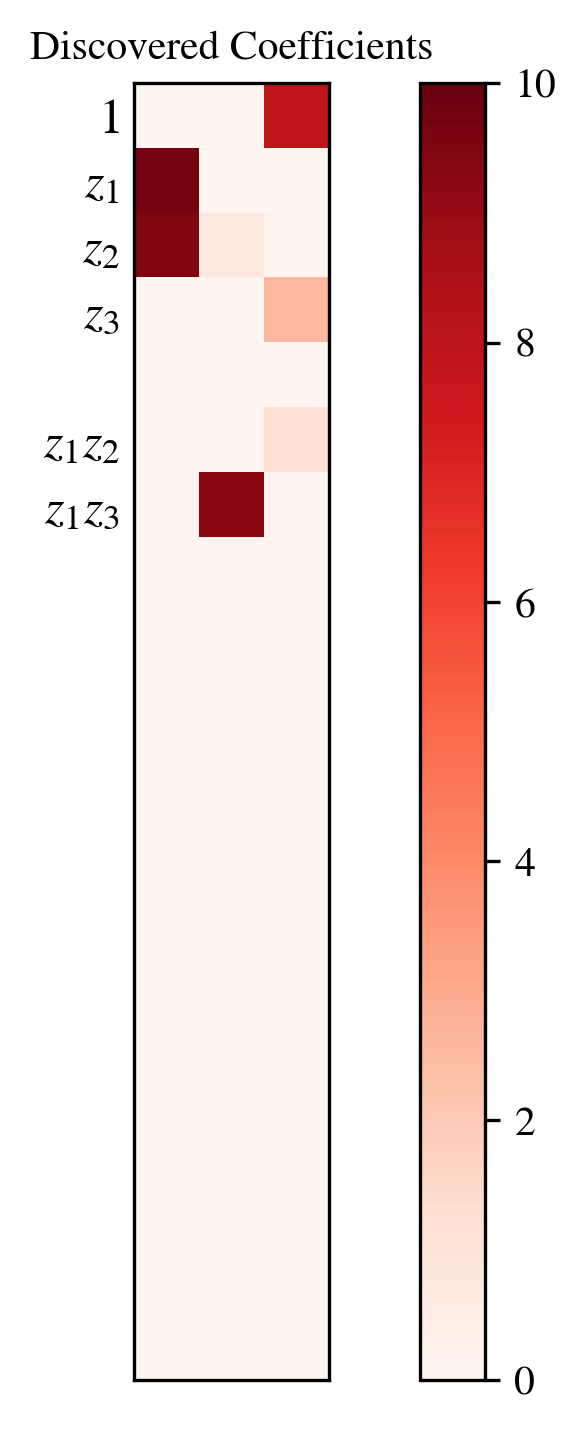

In [5]:
from plot_utils.plot_xi import plot_sindy_coefficients

plt.style.use("../plot_utils/plot_settings.mplstyle")
plot_sindy_coefficients(xi, library_hparams=library_hparams, folder_path=save_folder, file_name="xi_plot.png", save_figure=False)


### Plot difference between discovered coefficients ($\Xi$) and actual coefficients

The correct equations for the lorenz system are the following:

$$
\begin{aligned}
\dot{z}_1 =& \sigma (z_2 - z_1) \\



\dot{z}_2 =& z_1 (\rho - z_3) - z_2 \\



\dot{z}_3 =& z_1 z_2 - \beta z_3 \\

\end{aligned}
$$

with the standard paramater values $\sigma = 10$, $\beta = \frac{8}{3}$ and $\rho = 28$
That is:
$$
\begin{aligned}
\dot{z}_1 =& -10 z_1 + 10 z_2 \\
\dot{z}_2 =& 28 z_1 - z_2 - z_1 z_3 \\
\dot{z}_3 =& -\frac{8}{3}z_3 + z_1 z_2 \\
\end{aligned}
$$
We create an array with the theoretical values, in order to compare with the values from our model

In [6]:
from lorenzData import lorenz_coefficients

true_xi = lorenz_coefficients(
    poly_order=library_hparams["poly_order"],
    include_sine=library_hparams["include_sine"],
    include_constant=library_hparams["include_constant"],
)

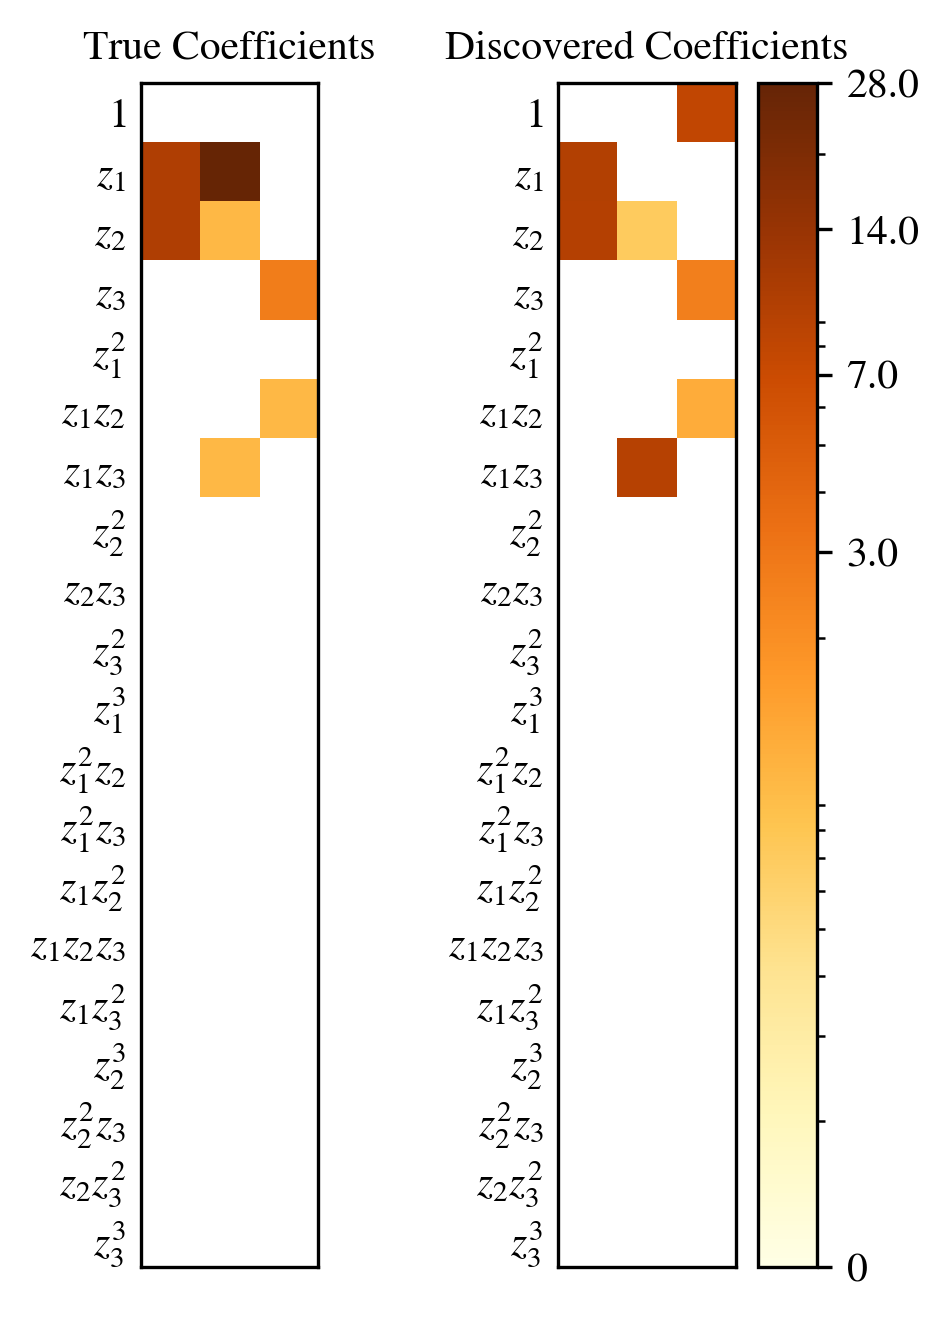

In [8]:
from plot_utils.plot_xi import compare_sindy_coefficients

plt.style.use("../plot_utils/plot_settings.mplstyle")
compare_sindy_coefficients(true_xi, xi, library_hparams = library_hparams, save_figure=True, file_name="xi_plot_lorenz.png")

### Plot losses

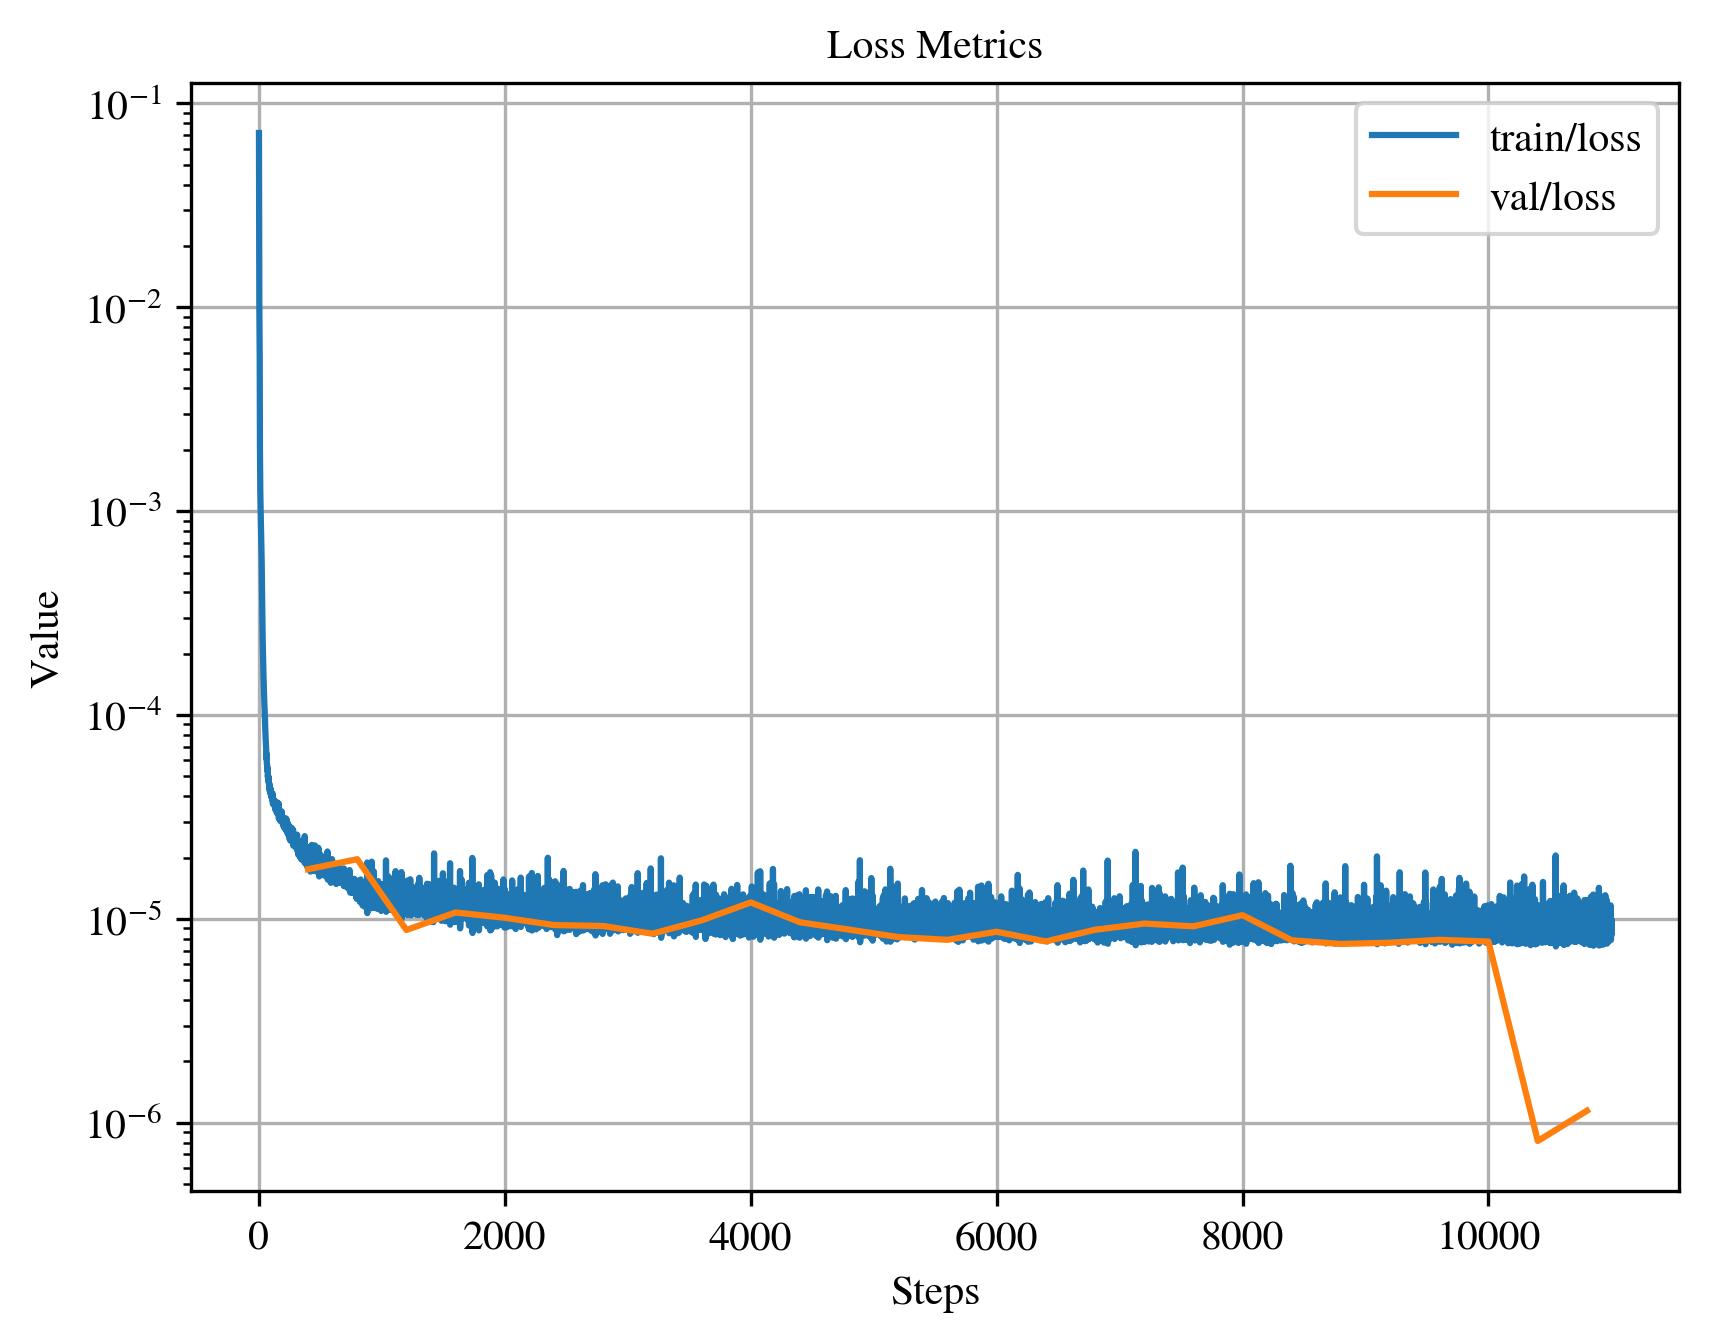

In [8]:
from plot_utils.metrics import RunMetrics
from plot_utils.plot_metrics import plot_metrics

metr = RunMetrics(model_path)

# Plot a single run
plot_metrics(metr, metric_names=["train/loss", "val/loss"], title="Loss Metrics")

### Plot actual trajectory

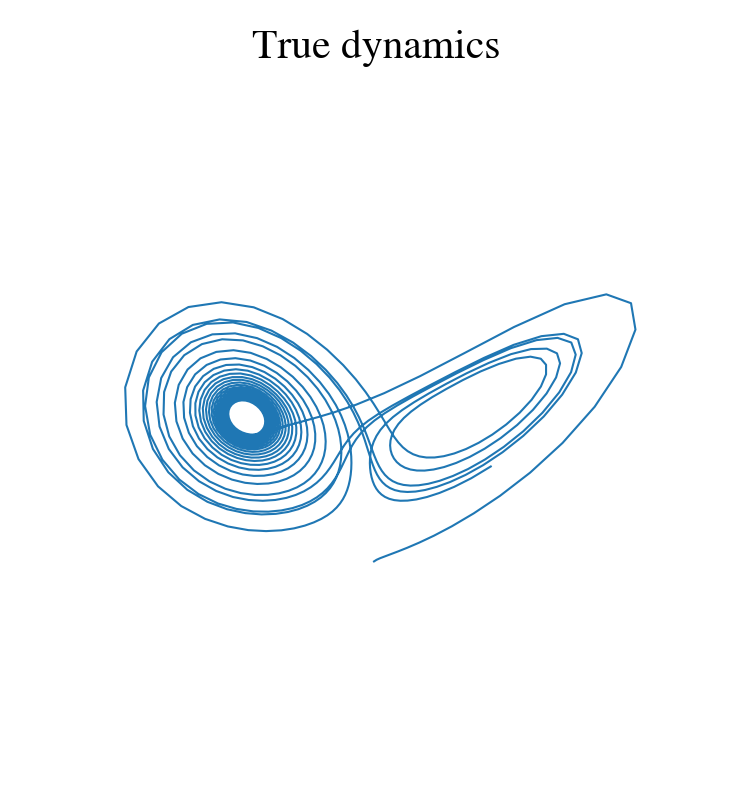

In [11]:
from lorenzSimulate import plot_single_trajectory
from sindySimulate import sindy_simulate

# Simulation parameters
initial_condition = np.array([1.0, 1.0, 1.0])
time = np.linspace(0, 100, 2000)

z_sim = sindy_simulate(initial_condition, time, true_xi, **library_hparams)

# print(z_sim)
plot_single_trajectory(z_sim, title="True dynamics")

### Plot discovered trajectory

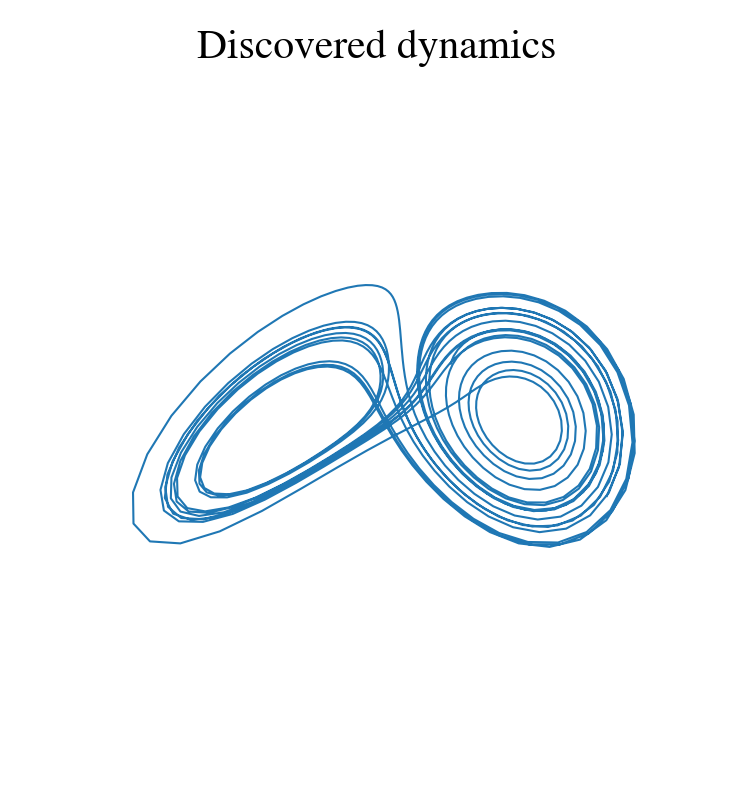

In [12]:
z_sim = sindy_simulate(initial_condition, time, xi, **library_hparams)

plot_single_trajectory(z_sim, title="Discovered dynamics")